In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

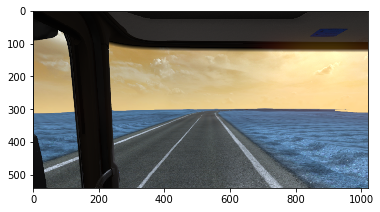

In [2]:
screen = cv2.imread('test2.png')
plt.imshow(screen)

In [3]:
def get_perspective_matrix(image):

    src = np.float32([
        [355, 500],
        [705, 500],
        [443, 400],
        [625, 400], 
    ])
    
    #perspective = image
    #perspective = cv2.circle(image, (src[0, 0], src[0, 1]), 5, (255, 50, 25), -1)
    #perspective = cv2.circle(image, (src[1, 0], src[1, 1]), 5, (255, 50, 25), -1)
    #perspective = cv2.circle(image, (src[2, 0], src[2, 1]), 5, (255, 50, 25), -1)
    #perspective = cv2.circle(image, (src[3, 0], src[3, 1]), 5, (255, 50, 25), -1)
    
    dst = np.float32([
        [355, 500],
        [705, 500],
        [355, 400],
        [705, 400]
    ])
    '''
    perspective = cv2.circle(image, (dst[0, 0], dst[0, 1]), 10, (0, 50, 250), -1)
    perspective = cv2.circle(image, (dst[1, 0], dst[1, 1]), 10, (0, 50, 250), -1)
    perspective = cv2.circle(image, (dst[2, 0], dst[2, 1]), 10, (0, 50, 250), -1)
    perspective = cv2.circle(image, (dst[3, 0], dst[3, 1]), 10, (0, 50, 250), -1)
    '''    
    #plt.imshow(perspective)
    
    perspective_transform_matrices = {'perspective': cv2.getPerspectiveTransform(src, dst),
    'perspective_inv': cv2.getPerspectiveTransform(dst, src)}

    return perspective_transform_matrices

perspective_matrices = get_perspective_matrix(screen)

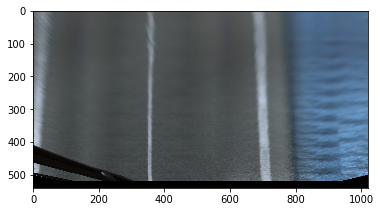

In [4]:
def top_view(perspective_matrices, front_view_image):
    img_size = (front_view_image.shape[1], front_view_image.shape[0])
    return cv2.warpPerspective(
        front_view_image,
        perspective_matrices.get('perspective'),
        img_size,
        flags=cv2.INTER_LINEAR)

top_view = top_view(perspective_matrices, screen)
plt.imshow(top_view)

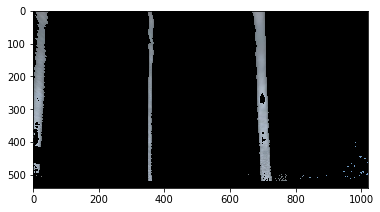

In [5]:
def filter_by_color(img):
    low_threshold = np.array([110, 110, 110], dtype=np.uint8)
    high_threshold = np.array([200, 200, 200], dtype=np.uint8)  
    
    yellow_mask = cv2.inRange(img, low_threshold, high_threshold)
    
    return yellow_mask

white_mask = filter_by_color(top_view)
image = cv2.bitwise_and(top_view, top_view, mask=white_mask)
plt.imshow(image)

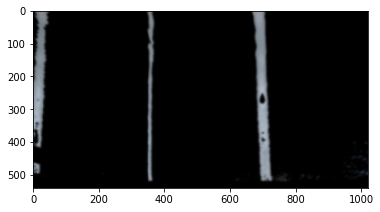

In [6]:
def gauss_blur(image, kernel=(15, 15)):
    return cv2.GaussianBlur(image, kernel, 0)

result_image = gauss_blur(image, (17,17))
plt.imshow(result_image)

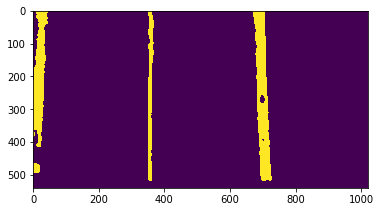

In [7]:
def to_binary(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    et3,threshold_image = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    threshold_image[threshold_image > 0] = 1
    return threshold_image

bin_image = to_binary(result_image)
plt.imshow(bin_image)

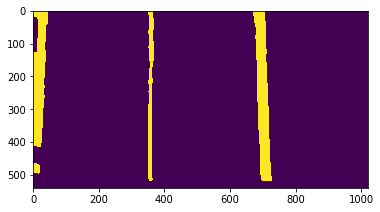

In [8]:
def morphology_transform(image):
    kernel = np.ones((20,20),np.uint8)
    result_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return result_image

result = morphology_transform(bin_image)    
plt.imshow(result)

In [9]:
import pandas as pd

def get_extreme_points_by_hist(histogram):
    binary = histogram > 0
    indexes = np.argwhere(binary == True)
    
    if indexes.shape[0] == 0:
        return np.array([])
     
    i = 0
    idx_list = []
    prev_idx = indexes[0]
        
    while i < indexes.size - 1:
        if (indexes[i+1] - indexes[i] != 1):
            idx_list.append([prev_idx[0], indexes[i]])
            prev_idx = indexes[i+1]
        i += 1
    idx_list.append([prev_idx, indexes[indexes.size-1]])
    idx_list = np.asarray(idx_list)
    points = ((idx_list[:,0] + idx_list[:,1]) / 2).astype(np.int)
    
    return points

def filter_extreme_points(extreme_points):
    distances = []
    for k in range(extreme_points.shape[0]):
        for l in range(k+1, extreme_points.shape[0]):
            distances.append([k,l,abs(abs(extreme_points[k]-extreme_points[l]) - 500)])
    distances = np.asarray(distances)
    pd_d = pd.DataFrame(distances)
    if pd_d.empty:
        return np.asarray([])
    qwe = pd_d.sort_values(by=[2,0,1])
    indxs = np.asarray(qwe[0:2][0:2])[:2,:2]
    if indxs.shape[0] == 2:
        points = np.array([extreme_points[indxs[0][0]],extreme_points[indxs[0][1]], extreme_points[indxs[1][0]],extreme_points[indxs[1][1]]])
    else:
        points = np.array([extreme_points[indxs[0][0]], extreme_points[indxs[0][1]]])
    points = np.sort(np.unique(points))
    
    return points

In [10]:
class Rectangle:
    def __init__(self, point1, point2):
        self.point1 = point1
        self.point2 = point2

class Point:
    def __init__(self,x_init,y_init):
        self.x = x_init
        self.y = y_init        

45


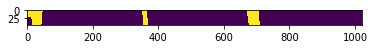

[ 23 359 688]


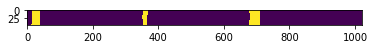

[ 25 360 693]


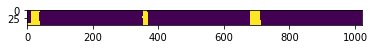

[ 19 360 695]


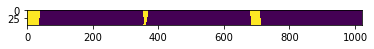

[ 20 361 695]


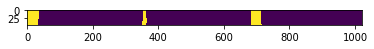

[ 18 358 698]


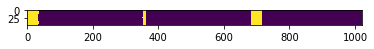

[ 17 357 699]


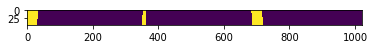

[ 17 357 701]


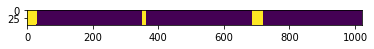

[ 15 357 702]


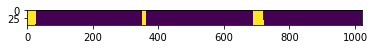

[ 13 356 704]


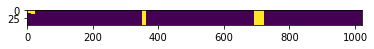

[ 12 356 706]


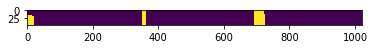

[ 10 356 708]


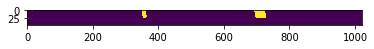

[ 14 357 710]


In [20]:
j = 0
margin = int(result_image.shape[0] / 12)
print(margin)

nonzero = result.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

line_1 = []
line_2 = []
line_3 = []

line_points = []
for j in range(12):
    histogram = np.sum(result[j*margin:margin*(j+1), :], axis = 0)
    plt.imshow(result[j*margin:margin*(j+1), :])
    plt.show()
    #plt.plot(hist)
    #plt.show()
    extreme_points = get_extreme_points_by_hist(histogram)
    
    if extreme_points.shape[0] == 3:
        points = filter_extreme_points(extreme_points)
        print(points)
        temp_points = []
        i = 0
        for point in points:
            x_low_right = point + 50
            x_high_left = point - 50
            y_low_right = j*margin
            y_high_left = (j+1)*margin
            
            
            
            point1 = Point(x_high_left, y_high_left)
            point2 = Point(x_low_right, y_low_right)
            temp_points.append(Rectangle(point1, point2))
        line_points.append(np.asarray(temp_points))

[23.0, 25.0, 19.0, 20.0, 18.0, 17.0, 17.0, 15.0, 13.0, 12.0, 10.0, 14.0]


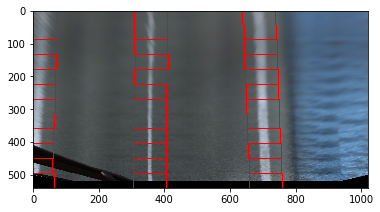

In [19]:
for rec_array in line_points:
    
    for r in rec_array:
        x1 = r.point1.x
        y1 = r.point1.y

        x2 = r.point2.x
        y2 = r.point2.y
        
        cv2.rectangle(top_view, (x1, y1), (x2, y2), (255,0,0), 2)

        
np.      
plt.imshow(top_view)

In [13]:
def getXYQuadratic (coeffs, limits):
    x = np.linspace (limits[0], limits[1], 100)
    y = np.add(np.add(coeffs [0], coeffs [1] * x), coeffs [2] * x * x)
    return x, y

def get_lane_lines_field(crop_image, coeff1, coeff2):
    """Draws lane and lane lines by coeffs
    """
    zero_layer = np.zeros_like(crop_image).astype(np.uint8)

    # from tips and tricks from lesson
    left_x, left_y = getXYQuadratic(coeff1, (0, 1080))
    right_x, right_y = getXYQuadratic(coeff2, (0, 1080))
    pts_left = np.array([np.transpose(np.vstack([left_y, left_x]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_y, right_x])))])
    pts = np.hstack((pts_left, pts_right))

    lanes_drown = np.dstack((zero_layer, zero_layer, zero_layer))
    lanes_drown = cv2.fillPoly(lanes_drown, np.int_([pts]), (255, 255, 255))

    #lanes_drown = draw_lane_line_top_view(lanes_drown, coeff1)
    #lanes_drown = draw_lane_line_top_view(lanes_drown, coeff2)

    return lanes_drown

def get_field(line_points, lanes_drown):
    k = 0
    for k in range(len(line_points)):
        if len(line_points[k]) < 3:
            temp = np.array([None, None, None])
            for point in line_points[k]:
                
                index = get_near_point(point.point1.x, line_points[k-1])
                temp[index] = point
            line_points[k] = temp
    qwe = 0
    for i in range(3):
        x_left = []
        y_left = []
        x_right = []
        y_right = []
        
        for rectangle in line_points:
            if(rectangle[i] != None):
                #print(len(rectangle))
                #print(rectangle)
                #print(rectangle[i].point1.x , rectangle[i].point1.y)
                x_left.append(rectangle[i].point1.x)
                y_left.append(rectangle[i].point1.y)


                x_right.append(rectangle[i].point2.x)
                y_right.append(rectangle[i].point2.y)

        z_left = np.polyfit(y_left, x_left, 2)
        z_right = np.polyfit(y_right, x_right, 2)

        qwe += get_lane_lines_field(lanes_drown[...,0], np.flip(z_left, axis=0), np.flip(z_right, axis=0))


        #lanes_drown = draw_lane_line_top_view(lanes_drown, np.flip(z_left, axis=0))
        #lanes_drown = draw_lane_line_top_view(lanes_drown, np.flip(z_right, axis=0))
    qwe[qwe > 0] = 1
    return qwe, z_left

def get_near_point(point, points_array):
    temp = 1000000
    i = 0
    for point_1 in points_array:
        if point_1 != None and abs(point_1.point1.x - point) < temp:
            temp = abs(point_1.point1.x - point)
            index = i
        i += 1
    return index

def draw_lane_line_top_view (img, coeffs):
    x, y = getXYQuadratic(coeffs, (0, 1080))
    pts = np.array([np.transpose(np.vstack([y, x]))]).astype(np.int32)
    print(img.shape)
    return cv2.polylines(img, [pts], False, (255, 0, 0), 5)

In [16]:
lanes_drown = np.dstack((result_image*255, result_image*255, result_image*255))
mask, z_left = get_field(line_points, result_image)

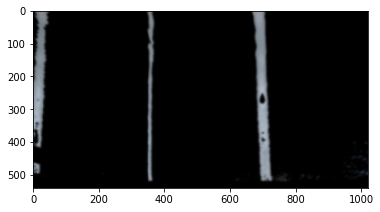

In [17]:
plt.imshow(result_image)